In [1]:
# Fix randomness and hide warnings
seed = 55

from pathlib import Path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
#os.environ['KERAS_BACKEND'] = "jax"
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
import keras_cv
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(seed)
print(f"TensorFlow version {tf.__version__}")
tfk.utils.set_random_seed(seed)


# Import other libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rc('font', size=14)
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, recall_score, precision_score, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image
from collections import Counter
import cv2

import keras
from keras import layers

# TF imports related to tf.data preprocessing
from tensorflow import clip_by_value
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import random as tf_random

# Set global policy for training precision
#tfk.mixed_precision.set_global_policy('mixed_float16')

cwd = Path(os.getcwd())
input_dir = cwd.parent / 'input'

print('input directory: ', input_dir)
print('current working directory: ', cwd)

TensorFlow version 2.16.1
input directory:  /kaggle/input
current working directory:  /kaggle/working


# Load dataset and inspect

Images shape:  (11951, 96, 96, 3)
labels shape:  (11951, 1)
Images dtype:  uint8
labels dtype:  uint8
max min images:  255 0
max min labels:  7 0


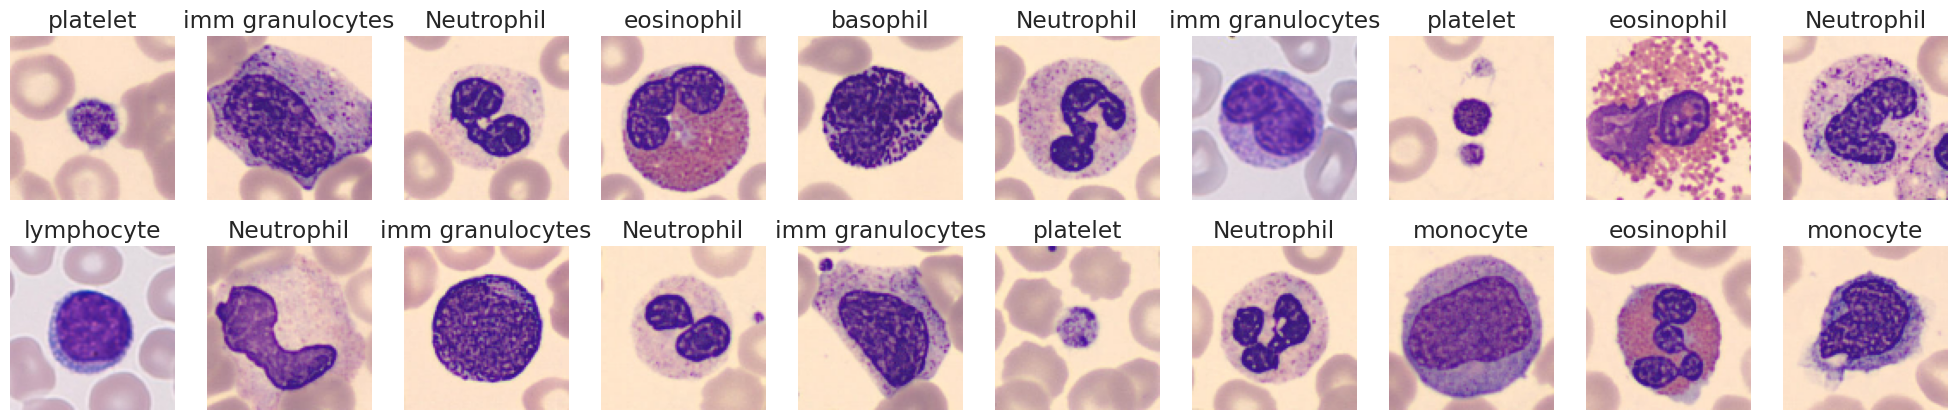

In [2]:
dataset_dir = input_dir / 'ann-h1-round1-dataset'
dataset_name = 'training_set_cleaned.npz'

data = np.load(dataset_dir / dataset_name)
X = data['images']
y = data['labels']
print('Images shape: ', X.shape)
print('labels shape: ', y.shape)
print('Images dtype: ', X.dtype)
print('labels dtype: ', y.dtype)
print('max min images: ', np.max(X), np.min(X))
print('max min labels: ', np.max(y), np.min(y))

labels = {0:'basophil',
          1: 'eosinophil',
          2: 'erythroblast',
          3: 'imm granulocytes',
          4: 'lymphocyte',
          5: 'monocyte',
          6: 'Neutrophil',
          7: 'platelet'}

fig, ax = plt.subplots(2,10, figsize=(25,5))
ax = ax.flatten()


for i in range(len(ax)):
  idx = random.randint(0,X.shape[0]-1)
  ax[i].imshow(X[idx,:,:,:])
  ax[i].axis('off')
  ax[i].set_title(f'{labels[y[idx][0]]}')
plt.show()

## compute class weights

In [3]:
labels_arr = np.array(list(labels.keys()))
y.ravel().shape

(11951,)

In [4]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y), 
                                     y=y.ravel())
print('class weights: ', class_weights)


weights = {}
for i, value in enumerate(class_weights):
    weights[i] = value

print('weights dict: ', weights)


class weights:  [1.7575     0.68557825 1.37684332 0.73844538 1.75957008 1.50592238
 0.64114807 0.90923615]
weights dict:  {0: 1.7575, 1: 0.6855782469022488, 2: 1.3768433179723503, 3: 0.7384453781512605, 4: 1.7595700824499412, 5: 1.505922379032258, 6: 0.6411480686695279, 7: 0.9092361533779671}


Transform y to categorical

In [5]:
y = tfk.utils.to_categorical(y)
print('labels categoriche: ',y.shape)

labels categoriche:  (11951, 8)


## Perform train test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=seed, stratify=y)

print('X train: ', X_train.shape)
print('y train: ',y_train.shape)

print('X test: ', X_test.shape)
print('y test: ',y_test.shape)

print('y_train type: ', y_train.dtype)
print('X_train type: ', X_train.dtype)

X train:  (10755, 96, 96, 3)
y train:  (10755, 8)
X test:  (1196, 96, 96, 3)
y test:  (1196, 8)
y_train type:  float64
X_train type:  uint8


In [7]:
def normalize(images):
    norm = tfkl.Normalization()
    norm.adapt(images)
    return norm(images)


X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

In [8]:
print('X train data')
print(X_train_norm.shape)
print(X_train_norm.dtype)


min_train = np.min(X_train_norm)
max_train = np.max(X_train_norm)
print(np.max(X_train_norm))
print(np.min(X_train_norm))

print('\nX test data')
print(X_test_norm.shape)
print(X_test_norm.dtype)

print(np.max(X_test_norm))
print(np.min(X_test_norm))

X train data
(10755, 96, 96, 3)
<dtype: 'float32'>
3.1575105
-4.7084937

X test data
(1196, 96, 96, 3)
<dtype: 'float32'>
3.1103053
-4.0352163


In [9]:
#X_train = X_train_norm
#X_test = X_test_norm
#del X_train_norm
#del X

## Convert to tensorflow dataset object

In [10]:
AUTO = tf_data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 96

Occhio che qua faccio un cast a float32

In [11]:
def to_dict(image, label):
    # label = tf.cast(label, dtype=tf.float16) # this is due to mixed_precision settings
    # image = tf.cast(image, dtype=tf.float32)
    return {"images": image, "labels": label}

def load_dataset(split):
    if split == 'train':
        ds = (
            tf_data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(10 * BATCH_SIZE, seed=seed)
            .map(to_dict, num_parallel_calls=AUTO)
            .batch(BATCH_SIZE)
        )
        return ds
    elif split == 'test':
        ds = (
            tf_data.Dataset.from_tensor_slices((X_test, y_test))
            .map(to_dict, num_parallel_calls=AUTO)
            .batch(BATCH_SIZE)
        )
        return ds


train_ds = load_dataset('train')
test_ds = load_dataset('test')


In [12]:
for sample in train_ds.take(1):
    print(sample.keys())  # Dovrebbe stampare: dict_keys(['images', 'labels'])
    print(sample["images"].shape)  # Stampa la shape delle immagini
    print(sample["labels"].shape)  # Stampa la shape delle label

for sample in train_ds.take(1):
    print(f"Min pixel value: {tf.reduce_min(sample['images'])}\nMax pixel value: {tf.reduce_max(sample['images'])}")
print(train_ds.element_spec)
print(test_ds.element_spec)

dict_keys(['images', 'labels'])
(32, 96, 96, 3)
(32, 8)
Min pixel value: 3
Max pixel value: 255
{'images': TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), 'labels': TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)}
{'images': TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), 'labels': TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)}


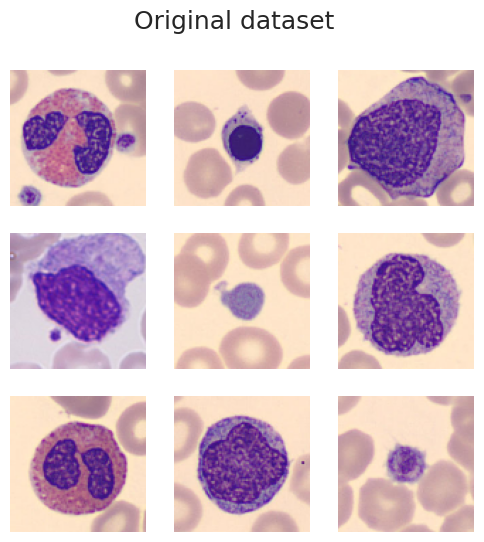

In [13]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()



visualize_dataset(train_ds, 'Original dataset')

# Random augmentation layer

In [14]:
AUGMENTATION_RATE = 0.9

rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=1,
    magnitude=0.5,
    magnitude_stddev=0.3,
    rate=AUGMENTATION_RATE,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs


# Channel shift layer

In [15]:
ch_shift = keras_cv.layers.RandomChannelShift(
    value_range=(0,255), factor=0.7, channels=3, seed=seed)


def apply_ch_shift(inputs):
    aug_prob = AUGMENTATION_RATE

    if random.random() < aug_prob:
        inputs['images'] = ch_shift(inputs['images'])
    return inputs


# Grid mask

In [16]:
gm = keras_cv.layers.GridMask(
    ratio_factor=(0.2, 0.5),
    rotation_factor=0.15,
    fill_mode="constant",
    fill_value=0.0,
    seed=seed
)

def apply_grid_mask(dataset):
    aug_prob = AUGMENTATION_RATE
    if random.random() < aug_prob:
        dataset['images'] = gm(dataset['images'])
        
    return dataset

# Catmix e mixup layer

In [17]:
cut_mix = keras_cv.layers.CutMix(seed=seed)
mix_up = keras_cv.layers.MixUp(seed=seed)


def apply_cut_mix_and_mix_up(samples):
    aug_prob=0.6
    samples['images'] = tf.cast(samples['images'],dtype=tf.float32)
    samples['labels'] = tf.cast(samples['labels'],dtype=tf.float32)
    if random.random() < AUGMENTATION_RATE:
        samples = cut_mix(samples)
        
    # Applica MixUp con la probabilità specificata
    if random.random() < AUGMENTATION_RATE:
        samples = mix_up(samples)
    samples['images'] = tf.cast(samples['images'], dtype=tf.uint8)
    return samples


# Apply augmentation pipeline
HERE with the .map method you can call all augmentation layers that you want and that you have defined above

In [18]:
train_ds_prep = (train_ds
                 .map(apply_rand_augment, num_parallel_calls=AUTO)
                 .map(apply_cut_mix_and_mix_up, num_parallel_calls=AUTO)
                )

# train_ds_prep = (train_ds
#                  .map(apply_rand_augment,  num_parallel_calls=AUTO)
#                  .map(apply_cut_mix_and_mix_up, num_parallel_calls=AUTO)
#                 )

In [19]:
#next(iter(train_ds_prep))

In [20]:
#visualize_dataset(train_ds_prep, title='augmented dataset')

## Concatenazione dei dataset

In [21]:


def convert(dataset):
    dataset['images'] = tf.cast(dataset['images'], dtype=tf.uint8)
    dataset['labels'] = tf.cast(dataset['labels'], dtype=tf.float64)
    return dataset

train_ds_prep1 = train_ds_prep.map(convert, num_parallel_calls=AUTO)
full_train_ds = train_ds.concatenate(train_ds_prep1)

# Shuffle con un buffer ampio (ad esempio 22000 immagini)
SHUFFLE_BUFFER_SIZE = 22000  # un po' più grande del totale dei dati
full_train_ds = (full_train_ds
                 .shuffle(SHUFFLE_BUFFER_SIZE))

print(full_train_ds.element_spec)

{'images': TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), 'labels': TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)}


In [22]:
#visualize_dataset(full_train_ds, title="Combined Dataset")

# Prepare for training

In [23]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    #images = tf.cast(images, tf.uint8)
    #labels = tf.cast(labels, tf.float64)
    return images, labels

# Prepare TRAIN dataset for training
train_dataset_ready = full_train_ds.map(preprocess_for_model, num_parallel_calls=AUTO)


# Prepare TEST dataset for training
test_dataset_ready = test_ds.map(preprocess_for_model, num_parallel_calls=AUTO)

# Implement PREFETCH
#train_dataset_ready = train_dataset.prefetch(AUTO)
#test_dataset_ready = test_dataset.prefetch(AUTO)

In [24]:
for images, labels in train_dataset_ready.take(1):
    print(f"Min pixel value: {tf.reduce_min(images)}\nMax pixel value: {tf.reduce_max(images)}")
    print(images.shape)
    print(images.dtype)
    print(labels.shape)
    print(labels.dtype)


Min pixel value: 2
Max pixel value: 255
(32, 96, 96, 3)
<dtype: 'uint8'>
(32, 8)
<dtype: 'float64'>


# Set up the model and train

In [25]:
base_model = tfk.applications.ConvNeXtBase(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
    include_preprocessing=True
)

base_model = tfk.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
)


base_model.trainable = False

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# CHOOSE HERE A LOSS FUNCTION
loss_1 = keras.losses.CategoricalFocalCrossentropy(
        alpha=class_weights,
        reduction="sum_over_batch_size",
        name="categorical_focal_crossentropy",
        )
loss_2 = tfk.losses.CategoricalCrossentropy()

In [27]:
print(X_train.dtype)

uint8


In [28]:
def build_model(input_shape, 
                output_shape, 
                loss_f,
                dropout_rate,
                augmentation=None, 
                learning_rate=1e-3, 
                plot_model=False, 
                name='model', 
                glob_avg_needed=False):
    
    input = tfkl.Input(shape=input_shape, name='Input_layer')
    
    x = tfk.applications.efficientnet.preprocess_input(input)

    # connect to the base model
    x = base_model(x)

    # insert a GAP layer after the backbone
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.LayerNormalization()(x)
    x = tfkl.Dropout(dropout_rate, name='dropout_gap')(x)

    # 1st dense layer of the classifier
    x = tfkl.Dense(units=1024, name='dense1')(x)
    x = tfkl.LayerNormalization()(x)
    x = tfkl.Activation('relu', name = 'HiddenActivation1')(x)
    x = tfkl.Dropout(dropout_rate, name='dropout_1', seed=seed)(x)
    
    # 2nd dense layer of the classifier
    x = tfkl.Dense(units=512, name='dense2')(x)
    x = tfkl.LayerNormalization()(x)
    x = tfkl.Activation('relu', name = 'HiddenActivation2')(x)
    x = tfkl.Dropout(dropout_rate, name='dropout_2', seed=seed)(x)

    # # 3rd dense layer of the classifier
    # x = tfkl.Dense(units=256, name='dense3')(x)
    # x = tfkl.LayerNormalization()(x)
    # x = tfkl.Activation('relu', name = 'HiddenActivation3')(x)
    # x = tfkl.Dropout(dropout_rate, name='dropout_3', seed=seed)(x)
    
    # # 4th dense layer of the classifier
    # x = tfkl.Dense(units=64, name='dense4')(x)
    # x = tfkl.LayerNormalization()(x)
    # x = tfkl.Activation('relu', name = 'HiddenActivation4')(x)
    # x = tfkl.Dropout(dropout_rate, name='dropout_4', seed=seed)(x)

    # output layer
    output = tfkl.Dense(units=output_shape, activation='softmax', name='output')(x)
    
    # Create a Model connecting input and output
    model = tfk.Model(inputs=input, outputs=output, name=name)


    
    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=loss_f,
                  optimizer=tfk.optimizers.Lion(learning_rate),
                  metrics=['accuracy'])
        
    if plot_model:
        model.summary()
        tfk.utils.plot_model(model, show_shapes=True, dpi=70)

    return model

In [29]:
lr = 1e-3
input_shape = (96,96,3)
output_shape = 8
dropout_rate = 0.1


model = build_model(input_shape=input_shape, 
                    output_shape=output_shape, 
                    loss_f=loss_1, 
                    dropout_rate=dropout_rate,
                    name='final_model',
                    glob_avg_needed=True,
                    learning_rate=lr,
                    plot_model=True)



Model: "final_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 3, 3, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 1536)           │         3,072 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_gap (Dropout)           │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 1024)           │         2,048 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenActivation1 (Activation)  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 512)            │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenActivation2 (Activation)  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,892,471 (49.18 MB)

 Trainable params: 2,108,936 (8.04 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [30]:
patience = 20
es = tfk.callbacks.EarlyStopping(monitor='val_accuracy',
                                 mode='max',
                                 patience=patience,
                                 restore_best_weights=True,
                                 start_from_epoch=10)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1
)

rlrop = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.995,
    patience=3,
    min_delta=0.0001
)


checkp = keras.callbacks.ModelCheckpoint(
    'checkpoint_model.keras',
    monitor="val_loss",
    save_best_only=True,
)

callbacks = [es,tensorboard_callback,rlrop, checkp]

## fit the model

In [31]:
EPOCHS = 500


history = model.fit(train_dataset_ready, 
          validation_data=test_dataset_ready,
          epochs=EPOCHS, 
          callbacks=callbacks).history

Epoch 1/500


I0000 00:00:1732103263.150675      72 service.cc:145] XLA service 0x7ed068004b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732103263.150727      72 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732103263.150732      72 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732103304.145148      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


674/674 ━━━━━━━━━━━━━━━━━━━━ 144s 116ms/step - accuracy: 0.5318 - loss: 0.9057 - val_accuracy: 0.8604 - val_loss: 0.1947 - learning_rate: 0.0010
Epoch 2/500
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.7857 - loss: 0.4145 - val_accuracy: 0.9130 - val_loss: 0.1283 - learning_rate: 0.0010
Epoch 3/500
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.8108 - loss: 0.3751 - val_accuracy: 0.9122 - val_loss: 0.1085 - learning_rate: 0.0010
Epoch 4/500
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.8086 - loss: 0.3640 - val_accuracy: 0.9197 - val_loss: 0.1062 - learning_rate: 0.0010
Epoch 5/500
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.8238 - loss: 0.3500 - val_accuracy: 0.9239 - val_loss: 0.0974 - learning_rate: 0.0010
Epoch 6/500
674/674 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.8343 - loss: 0.3359 - val_accuracy: 0.9247 - val_loss: 0.0934 - learning_rate: 0.0010
Epoch 7/500
674/674 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8370 - loss

In [32]:
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = f'{model.name}_' + str(final_val_accuracy) + '.keras'
model.save(model_filename)

Final validation accuracy: 95.23%


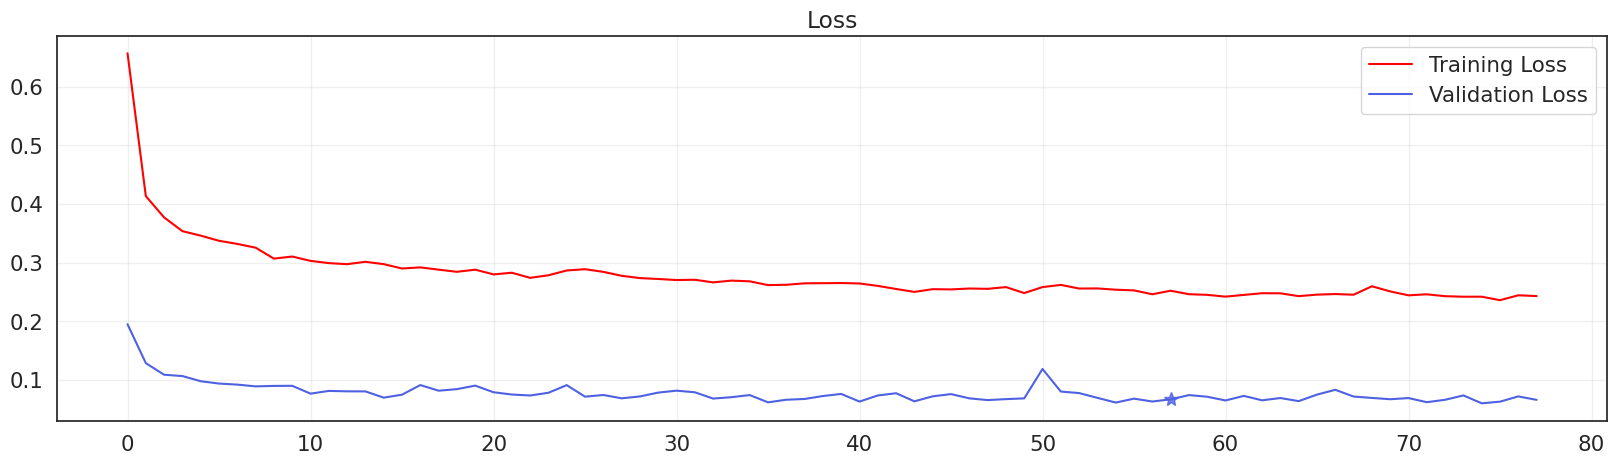

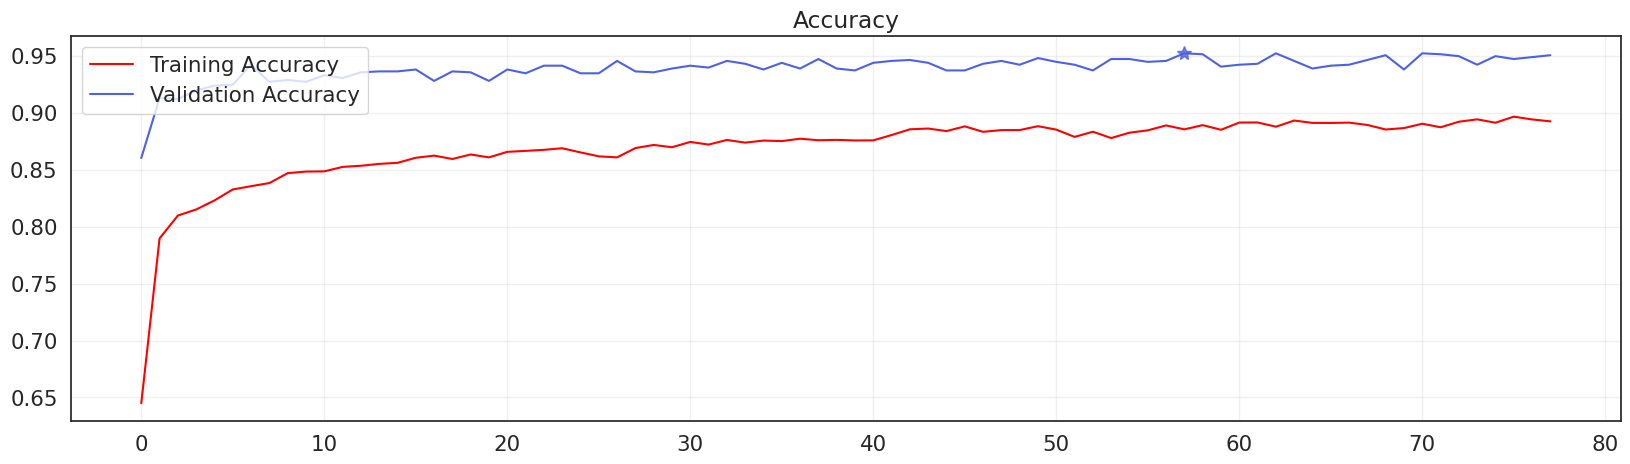

In [33]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    
    # Plot the re-trained and the transfer learning MobileNetV2 training histories
    plt.figure(figsize=(20,5))
    plt.plot(history['loss'], color='#FF0000', label='Training Loss')
    plt.plot(history['val_loss'], color='#4D61E2', label='Validation Loss')
    plt.plot(best_epoch, history['val_loss'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.grid(alpha=.3)
    
    plt.figure(figsize=(20,5))
    plt.plot(history['accuracy'], color='#FF0000', label='Training Accuracy')
    plt.plot(history['val_accuracy'], color='#4D61E2', label='Validation Accuracy')
    plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)
    
    plt.show()

plot_history(history)

# Fine Tuning 1

In [34]:
# for layer in model.layers[2].layers[-40:]:
#     if not isinstance(layer, tfkl.BatchNormalization):
#          layer.trainable = True

# model.summary(expand_nested=True, show_trainable=True)
# tfk.utils.plot_model(model,  show_trainable=True, show_shapes=True, dpi=70)

In [35]:
# optimizer = tfk.optimizers.Lion(learning_rate=1e-5)

# loss_f1 = keras.losses.CategoricalFocalCrossentropy(
#         alpha=class_weights,
#         reduction="sum_over_batch_size",
#         name="categorical_focal_crossentropy",
#         )
# model.compile(
#     optimizer=optimizer, loss=loss_f1, metrics=["accuracy"]
# )
# EPOCHS = 50


# history = model.fit(train_dataset_ready, 
#           validation_data=test_dataset_ready,
#           epochs=EPOCHS, 
#           callbacks=callbacks).history

In [36]:
# final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
# print(f'Final validation accuracy: {final_val_accuracy}%')

# # Save the trained model to a file, including final accuracy in the filename
# model_filename = f'{model.name}_'+ 'FT1_' + str(final_val_accuracy) + '.keras'
# model.save(model_filename)
# plot_metrics_from_dict(history)

# Fine Tuning 2

In [37]:
# for layer in model.layers[2].layers[-70:]:
#     if not isinstance(layer, tfkl.BatchNormalization):
#          layer.trainable = True

# model.summary(expand_nested=True, show_trainable=True)
# tfk.utils.plot_model(model,  show_trainable=True, show_shapes=True, dpi=70)

In [38]:
# optimizer = tfk.optimizers.Lion(learning_rate=1e-6)
# loss_f1 = keras.losses.CategoricalFocalCrossentropy(
#         alpha=class_weights,
#         reduction="sum_over_batch_size",
#         name="categorical_focal_crossentropy",
#         )
# model.compile(
#     optimizer=optimizer, loss=loss_f1, metrics=["accuracy"]
# )
# EPOCHS = 10


# history = model.fit(train_dataset_ready, 
#           validation_data=test_dataset_ready,
#           epochs=EPOCHS, 
#           callbacks=callbacks).history

In [39]:
# final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
# print(f'Final validation accuracy: {final_val_accuracy}%')

# # Save the trained model to a file, including final accuracy in the filename
# model_filename = f'{model.name}_'+ 'FT2_' + str(final_val_accuracy) + '.keras'
# model.save(model_filename)
# plot_metrics_from_dict(history)